# Feature Engineering & Selection of Feature Sets

In the following notebook, I will look at a number of different ways to create a feature set to use as the training data for the neural network classification model. The first steps are to import the required libraries and then import the data sets. There are two related datasets; the dataframe containing the flux and time informormation and then the dataframe containing meta details regarding to each individual astronomical object.

The first feature engineering method I try is manual feature generation. I create basic features based on standard aggregate statistical measures like mean, max, skew of the flux information and append it to the meta dataframe. This will be the first feature set I train the classifier with. Next, I will use feature selection tools to decrease the dimensionality of this feature set. This will be the second set of data that I will train the classifer with.

The second feature engineering method I try is to create features using the Featuretools library. First, I define some primative and transform aggregations for the tool to use. The dimension of features using this tool can become very large so I will use similar feature selection tools as in the first method to decrease the number of features which will become the third set I use to train the classifier. Finally, I will allow Featuretools to automatically create a feature set that will become the fourth set I use to train the classifier.

## Preliminaries

###  Import Libraries

In [1]:
# data/math manipulation
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns instead of truncated list when using head/tail function
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# garbage collection
import gc

# file paths/saving
from pathlib import Path
import pickle

# feature selection tools
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import featuretools as ft

### Import Data

The datasets imported here are the cleaned versions saved after the EDA task.

In [2]:
data_folder = Path('C:/Users/Kathleen Lange/MSDS692_Practicum_I')
train = pd.read_pickle(data_folder / 'training.pk')
train_meta = pd.read_pickle(data_folder / 'training_meta.pk')

In [3]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


## Manual Feature Generation

The following feature idea comes from [CPMP's and Grzegorz's discussion](https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696) on the competition website. For objects that are detected (equal to 1), take the difference between the maximum and minimum detection times. This feature helps to sort out the differences between light curves that indicate a single event such as supernovae and light curves that indicate periodic objects like a binary star system or cepheid.

In [4]:
det_grp = train[train['detected'] == 1] # subset of only the 'detected' observations
det_grp_mjd = det_grp.groupby('object_id')['mjd']

# Take the total time of the detected events (max mjd - min mjd). 
# Use this total time in place for all the values where detected = 1 in the original dataframe.

train['mjd_diff'] = det_grp_mjd.transform('max') - det_grp_mjd.transform('min') 
# transform function add the aggregate value for the same number of records as the original data set

In the EDA portion of this project, I decided to not do a strict time-series classification. Therefore, I would need to create aggregate features to feed to the machine learning algorithm instead. The following features are mostly borrowed from [Oliver's kernal](https://www.kaggle.com/ogrellier/plasticc-in-a-kernel-meta-and-data). I added a few more features based on the competition organizers [getting started kernal](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit).

In [5]:
gc.enable()

train['flux_ratio_sq'] = np.power(train.flux / train.flux_err, 2.0) 
train['flux_weight'] = train.flux * train.flux_ratio_sq 
train['flux_weight_sum'] = train.groupby('object_id').flux_ratio_sq.transform('sum')
train['flux_rsq_sum'] = train.groupby('object_id').flux_weight.transform('sum') 
train['flux_w_mean'] = train.flux_weight_sum / train.flux_rsq_sum 
train['flux_median'] = train.groupby('object_id').flux.transform('median')
train['MAD'] = np.abs(train.flux - train.flux_median) / train.flux_w_mean
train['flux_diff'] = np.abs(train.flux - train.flux_w_mean)

aggs = {
    'object_id': ['count'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean','std'],
    'flux_ratio_sq': ['sum','skew'],
    'flux_weight': ['sum','skew'],
    'mjd_diff': ['mean'],
    'MAD': ['median'],
    'flux_diff': ['mean']
}

df_agg_train = train.groupby('object_id').agg(aggs)

new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
df_agg_train.columns = new_columns

#additional computed features
df_agg_train['flux_weighted_mean'] = df_agg_train['flux_weight_sum'] / df_agg_train['flux_ratio_sq_sum']

df_agg_train['flux_amp'] = df_agg_train['flux_max'] - df_agg_train['flux_min']
df_agg_train['flux_norm_amp_mean'] = (df_agg_train['flux_max'] - df_agg_train['flux_min']) / df_agg_train['flux_mean']
df_agg_train['flux_norm_amp_w_mean'] = (df_agg_train['flux_max'] - df_agg_train['flux_min']) / df_agg_train['flux_weighted_mean']
df_agg_train['beyond_1std'] = sum(df_agg_train['flux_diff_mean'] > df_agg_train['flux_std']) / df_agg_train['object_id_count']

del df_agg_train['object_id_count'], df_agg_train['flux_diff_mean']

gc.collect()

83

In [6]:
print(df_agg_train.info())
df_agg_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7848 entries, 615 to 130779836
Data columns (total 25 columns):
flux_min                7848 non-null float64
flux_max                7848 non-null float64
flux_mean               7848 non-null float64
flux_median             7848 non-null float64
flux_std                7848 non-null float64
flux_skew               7848 non-null float64
flux_err_min            7848 non-null float64
flux_err_max            7848 non-null float64
flux_err_mean           7848 non-null float64
flux_err_median         7848 non-null float64
flux_err_std            7848 non-null float64
flux_err_skew           7848 non-null float64
detected_mean           7848 non-null float64
detected_std            7848 non-null float64
flux_ratio_sq_sum       7848 non-null float64
flux_ratio_sq_skew      7848 non-null float64
flux_weight_sum         7848 non-null float64
flux_weight_skew        7848 non-null float64
mjd_diff_mean           7848 non-null float64
MAD_median  

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,detected_std,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_weight_sum,flux_weight_skew,mjd_diff_mean,MAD_median,flux_weighted_mean,flux_amp,flux_norm_amp_mean,flux_norm_amp_w_mean,beyond_1std
object_id,,,,,,,,,,,,,,,,,,,,,,,,,
615,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,0.226295,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,-96547.262044,-327.742307,1761.066406,-14.306331,-5.373326,1.031250
713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,0.377423,5.886068e+03,3.439423,-2.875087e+04,-3.454554,846.8017,-26.005338,-4.884564,29.506064,-20.730002,-6.040676,1.037143
730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,0.255022,4.124452e+03,5.480405,1.046502e+05,5.989138,78.7737,42.073919,25.373110,66.469870,29.315018,2.619697,1.100000
745,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,0.379469,9.416165e+04,9.611274,1.439125e+07,11.141069,123.6872,344.233035,152.835617,236.289675,26.521968,1.546038,1.034188
1124,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,0.379041,3.432418e+04,7.868462,3.015599e+06,7.908174,133.9113,172.633940,87.856390,160.143942,22.411225,1.822792,1.031250


In [7]:
# merge all features into a single dataframe
full_df = train_meta.merge(df_agg_train, on='object_id')
# full_df = full_df.merge(df_agg_train_pass, on='object_id')

Also, I had a hunch that some of the flux values should be normalized using the redshift value which was bolstered by [Silogram's and Mike's discussion](https://www.kaggle.com/c/PLAsTiCC-2018/discussion/75059) (Mike's note #4). Therefore, I will create new weighted columns using the flux features and the redshifted. For the redshift value I choose to use the hostgal_photoz column because as the challenge creators mention in the data introduction, each object in the test set will have a photoz value but few will have a specz value (although this one is more precise measurement). 

In [8]:
columns_to_divide = ['flux_min', 'flux_max', 
                     'flux_mean', 'flux_median', 
                     'flux_ratio_sq_sum', 'flux_weighted_mean', 
                     'flux_amp']
new_column_names = ['flux_min_wz', 'flux_max_wz', 
                     'flux_mean_wz', 'flux_median_wz', 
                     'flux_ratio_sq_sum_wz', 'flux_weighted_mean_wz', 
                     'flux_amp_wz']

# create new dataframe with z weighted flux features
# add 1 to avoid division by zero for galactic objects
new_df = full_df[columns_to_divide].div(full_df['hostgal_photoz'] + 1, axis=0) 

# create new column names for features
new_df.columns = new_column_names           

# add newly created features from z weighted dataframe to original features dataframe
# merge two dataframes on the index of each
full_df = full_df.merge(new_df, left_index=True, right_index=True)

### Review and Clean Data

In [9]:
print(full_df.info())
full_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7848 entries, 0 to 7847
Data columns (total 41 columns):
object_id                7848 non-null int64
ddf                      7848 non-null int64
hostgal_specz            7848 non-null float64
hostgal_photoz           7848 non-null float64
hostgal_photoz_err       7848 non-null float64
distmod                  7848 non-null float64
mwebv                    7848 non-null float64
target                   7848 non-null int64
origin                   7848 non-null category
flux_min                 7848 non-null float64
flux_max                 7848 non-null float64
flux_mean                7848 non-null float64
flux_median              7848 non-null float64
flux_std                 7848 non-null float64
flux_skew                7848 non-null float64
flux_err_min             7848 non-null float64
flux_err_max             7848 non-null float64
flux_err_mean            7848 non-null float64
flux_err_median          7848 non-null float64
flux_

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,origin,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,detected_std,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_weight_sum,flux_weight_skew,mjd_diff_mean,MAD_median,flux_weighted_mean,flux_amp,flux_norm_amp_mean,flux_norm_amp_w_mean,beyond_1std,flux_min_wz,flux_max_wz,flux_mean_wz,flux_median_wz,flux_ratio_sq_sum_wz,flux_weighted_mean_wz,flux_amp_wz
0,615,1,0.0000,0.0000,0.0000,0.0000,0.017,92,galactic,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,0.226295,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,-96547.262044,-327.742307,1761.066406,-14.306331,-5.373326,1.031250,-1100.440063,660.626343,-123.096998,-89.477524,2.929669e+06,-327.742307,1761.066406
1,713,1,1.8181,1.6267,0.2552,45.4063,0.007,88,extragalactic,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,0.377423,5.886068e+03,3.439423,-2.875087e+04,-3.454554,846.8017,-26.005338,-4.884564,29.506064,-20.730002,-6.040676,1.037143,-5.609768,5.623362,-0.541878,-0.332369,2.240860e+03,-1.859582,11.233131
2,730,1,0.2320,0.2262,0.0157,40.2561,0.021,42,extragalactic,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,0.255022,4.124452e+03,5.480405,1.046502e+05,5.989138,78.7737,42.073919,25.373110,66.469870,29.315018,2.619697,1.100000,-15.625356,38.582661,1.849155,0.333691,3.363604e+03,20.692473,54.208017
3,745,1,0.3037,0.2813,1.1523,40.7951,0.007,90,extragalactic,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,0.379469,9.416165e+04,9.611274,1.439125e+07,11.141069,123.6872,344.233035,152.835617,236.289675,26.521968,1.546038,1.034188,-12.092768,172.321246,6.953255,0.808472,7.348915e+04,119.281680,184.414013
4,1124,1,0.1934,0.2415,0.0176,40.4166,0.024,90,extragalactic,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,0.379041,3.432418e+04,7.868462,3.015599e+06,7.908174,133.9113,172.633940,87.856390,160.143942,22.411225,1.822792,1.031250,-13.325617,115.666685,5.755700,0.919282,2.764735e+04,70.766323,128.992301


There are a total of 43 columns, resulting in 41 unique features, plus an object_id variable that can act like an index value and a target variable. After all of the aggregations, I need to check to see if any NaN values were created.

In [10]:
# check for NaN values
full_df.isna().any()[lambda x: x]

Series([], dtype: bool)

No NaNs were created.

The final step is to save the dataframe into a file that can be read into the machine learning algorithm for training. Machine learning algorithms usually cannot take a categorical value and only can be fed numerical values. Therefore, I will convert the one categorical value, origin, back to a numerical value. Next, I will convert the columns into the minimum space variable type that each can be to help make the training of the classifier be faster and take less memory. All of the float columns can be converted from float64 objects to float32 objects. The 'target', 'ddf', 'origin' columns can all be converted to int8 values. The 'object_id' variable will be set as the index and converted to an int32 object. 

In [11]:
def convert_variables(df):
    for col in df.columns:
        col_type = df[col].dtype
        if (col_type == 'float64'):
            df[col] = df[col].astype('float32')
        if (col_type == 'int64'):
            df[col] = df[col].astype('int8')
    return df

In [12]:
print('memory usage: {:.2f} MB'.format(full_df.memory_usage().sum() / 2**20))

memory usage: 2.77 MB


In [13]:
full_df['origin'] = full_df.origin.cat.codes
full_df['object_id'] = full_df['object_id'].astype('int32')
full_df = full_df.set_index('object_id')
full_df = convert_variables(full_df)

In [14]:
print('memory usage: {:.2f} MB'.format(full_df.memory_usage().sum() / 2**20))

memory usage: 1.19 MB


The memory usage after the conversion of the columns decreased by 1.58 MBs.

Finally, I will standardize the features using sklearn's StandardScalar() function. This will scale all of the feature columns to unit variance. Standardized features allow the neural network to be more efficient and help prevent values from growing out of control or being completely eliminated in the different layers.

In [15]:
full_df.columns #get all column names so I can subtract those that do not need to be scaled (i.e. bools)

Index(['ddf', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err',
       'distmod', 'mwebv', 'target', 'origin', 'flux_min', 'flux_max',
       'flux_mean', 'flux_median', 'flux_std', 'flux_skew', 'flux_err_min',
       'flux_err_max', 'flux_err_mean', 'flux_err_median', 'flux_err_std',
       'flux_err_skew', 'detected_mean', 'detected_std', 'flux_ratio_sq_sum',
       'flux_ratio_sq_skew', 'flux_weight_sum', 'flux_weight_skew',
       'mjd_diff_mean', 'MAD_median', 'flux_weighted_mean', 'flux_amp',
       'flux_norm_amp_mean', 'flux_norm_amp_w_mean', 'beyond_1std',
       'flux_min_wz', 'flux_max_wz', 'flux_mean_wz', 'flux_median_wz',
       'flux_ratio_sq_sum_wz', 'flux_weighted_mean_wz', 'flux_amp_wz'],
      dtype='object')

In [16]:
full_df_scaled = full_df.copy() #create copy of dataframe
scaler = StandardScaler()
col_names = ['hostgal_specz', 'hostgal_photoz',
             'hostgal_photoz_err', 'distmod', 'mwebv',
             'flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std',
             'flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean',
             'flux_err_median', 'flux_err_std', 'flux_err_skew', 'detected_mean',
             'detected_std', 'flux_ratio_sq_sum', 'flux_ratio_sq_skew',
             'flux_weight_sum', 'flux_weight_skew', 'mjd_diff_mean', 'MAD_median',
             'flux_weighted_mean', 'flux_amp', 'flux_norm_amp_mean',
             'flux_norm_amp_w_mean', 'beyond_1std', 'flux_min_wz', 'flux_max_wz',
             'flux_mean_wz', 'flux_median_wz', 'flux_ratio_sq_sum_wz',
             'flux_weighted_mean_wz', 'flux_amp_wz'] # only these columns need to be scaled

features = full_df_scaled[col_names] # create subset dataframe with only columns needed to be scaled
features = scaler.fit_transform(features.values) # scale features

full_df_scaled[col_names] = features # add scaled features back to dataframe

### Save All Manual Features Dataframe

In [17]:
# save dataframe for training set 1
with open(data_folder / 'all_manual_features.pk', 'wb') as f:
    pickle.dump(full_df, f)
    
with open(data_folder / 'all_manual_features_scaled.pk', 'wb') as f:
    pickle.dump(full_df_scaled, f)

### Dimensionality Reduction

In feature engineering, often times there are many features that are created, but having too many features fed into a machine learning algorithm can be problematic with regards to amount of memory required, the accuracy of the model and the time it takes to get a result. Therefore, there are some methods of reducing the dimensionality of the features, especially ones that may not contribute as much or are highly correlated. Sample code for feature reduction ideas such univariate selection, feature importance and correlation matrices follow from this blog post: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e/.

Further feature reduction techniques such as using a variance threshold or principal component analysis can also be used but will not be currently explored, but may prove useful in imporoving the accuracy of the model at a later time.

#### Univariate Selection

I will use three statistical tests to understand which features are the most important to use: Chi^2, Mutual Information, and ANOVA F-score. First, I need to pull out the target variable as opposed to the proposed features. Then I create a function that takes the features, the target variable, the statistical test and the number of top features desired as inputs. The function then returns the list of top n important features.

In [18]:
target_vals = full_df.target # pull out the target values from the dataframe
full_df.drop(columns=['target'], inplace=True) # remove the target variable from the proposed feature set

full_df.drop(columns=['hostgal_photoz', 'hostgal_photoz_err', 'hostgal_specz'], inplace=True) 
# redshift already accounted for in distmod calculation and in the redshift weighted flux aggregations

full_df.drop(columns=columns_to_divide, inplace=True)
# flux and flux columns weighted by the redshift are highly correlated so just use the weighted columns

In [19]:
# following code adapted from here: 
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
def feature_selection(X, y, fxn, num_feats):
    
    #apply SelectKBest class to extract top 10 best features
    bestfeatures = SelectKBest(score_func=fxn, k=num_feats)
    fit = bestfeatures.fit(X, y)
    dfscores = pd.Series(fit.scores_) # scores
    dfcolumns = pd.Series(X.columns) # create dataframe of feature names
    featureScores = pd.concat([dfcolumns,dfscores],axis=1) # concat two dataframes
    featureScores.columns = ['Specs','Score']  # naming the dataframe columns
    # print(featureScores.nlargest(num_feats,'Score'))  # print the top num_feats with the highest scores
    return featureScores.nlargest(num_feats,'Score') # return dataframe of top num_feats with the highest scores

##### Chi2

Chi^2 tests are only applicable to categorical or nominal data (and therefore only takes positive values). I originally used this test, but most of the data at hand is numeric/decimal. I already know that I will use origin as a feature from the EDA portion of this project. The only other categorical feature might be ddf, so performing the following lines of code is unnecessary.

##### F-score

The F-score test is based on ANOVA and can be used for classification tasks. The F-test checks for linear relationships between a feature and the target variable. 

In [20]:
feature_selection(full_df, target_vals, f_classif, 15)

,Specs,Score
3,origin,inf
1,distmod,7.421629e+04
17,mjd_diff_mean,2.273951e+03
16,flux_weight_skew,1.460854e+03
12,detected_mean,8.178295e+02
5,flux_skew,5.119138e+02
14,flux_ratio_sq_skew,3.883026e+02
26,flux_ratio_sq_sum_wz,1.660486e+02
13,detected_std,1.618972e+02
6,flux_err_min,1.330221e+02


##### Mutual Information

One drawback to the F-test is that not all feature/target relationships are linear. A highly linear/correlated feature will score higher than a feature that is not linear, although may still show a strong non-linear relationship to the target.

Using the mutual information statistic checks how dependent one feature is on another. It is less reliant on linear relationships between variables, so could be a better statistic in some cases.

In [21]:
feature_selection(full_df, target_vals, mutual_info_classif, 15)

,Specs,Score
1,distmod,0.768750
17,mjd_diff_mean,0.654599
16,flux_weight_skew,0.624779
3,origin,0.605963
19,flux_norm_amp_mean,0.536172
5,flux_skew,0.466850
25,flux_median_wz,0.464388
18,MAD_median,0.445776
22,flux_min_wz,0.433026
6,flux_err_min,0.407821


#### Feature Importance

Feature importance is a mehtod built into tree based classification methods in sklearn. The importances are calculated by how much each variable contributes to classifying the target variable. 

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0053479  0.11809133 0.01835056 0.06791394 0.02503367 0.05051288
 0.02745108 0.01928077 0.0189641  0.02031956 0.01899669 0.0201323
 0.04750807 0.04068538 0.03689104 0.02084953 0.10096793 0.09012993
 0.02223057 0.02428904 0.02424339 0.01796299 0.02145831 0.02407558
 0.02377549 0.02567747 0.02144627 0.0233922  0.02402204]


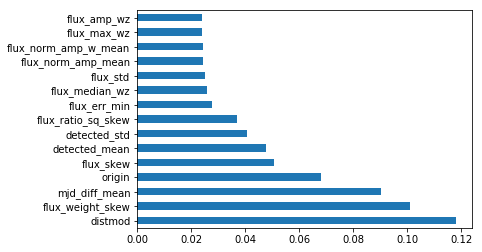

In [22]:
model = ExtraTreesClassifier() 
#could also use RandomForestClassifer() or another tree classifier and results should be very similar

model.fit(full_df,target_vals)

print(model.feature_importances_) 

feat_importances = pd.Series(model.feature_importances_, index=full_df.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


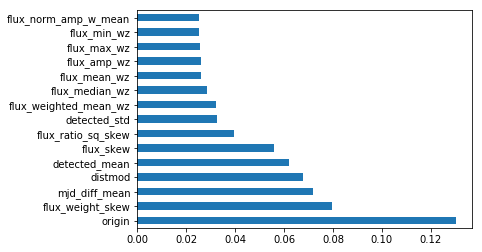

In [23]:
model = ExtraTreesClassifier() 
model.fit(full_df,target_vals)
feat_importances = pd.Series(model.feature_importances_, index=full_df.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

Using the above two methods of feature reduction, univariate selection and feature importance, gives mostly the same features. However, many of the above features are correlated so I will look at a correlation matrix and pull out the features that are highly correlated because they will not add a lot to the ability of the classifier to distinguish a class.

#### Correlation Matrix with Heatmap

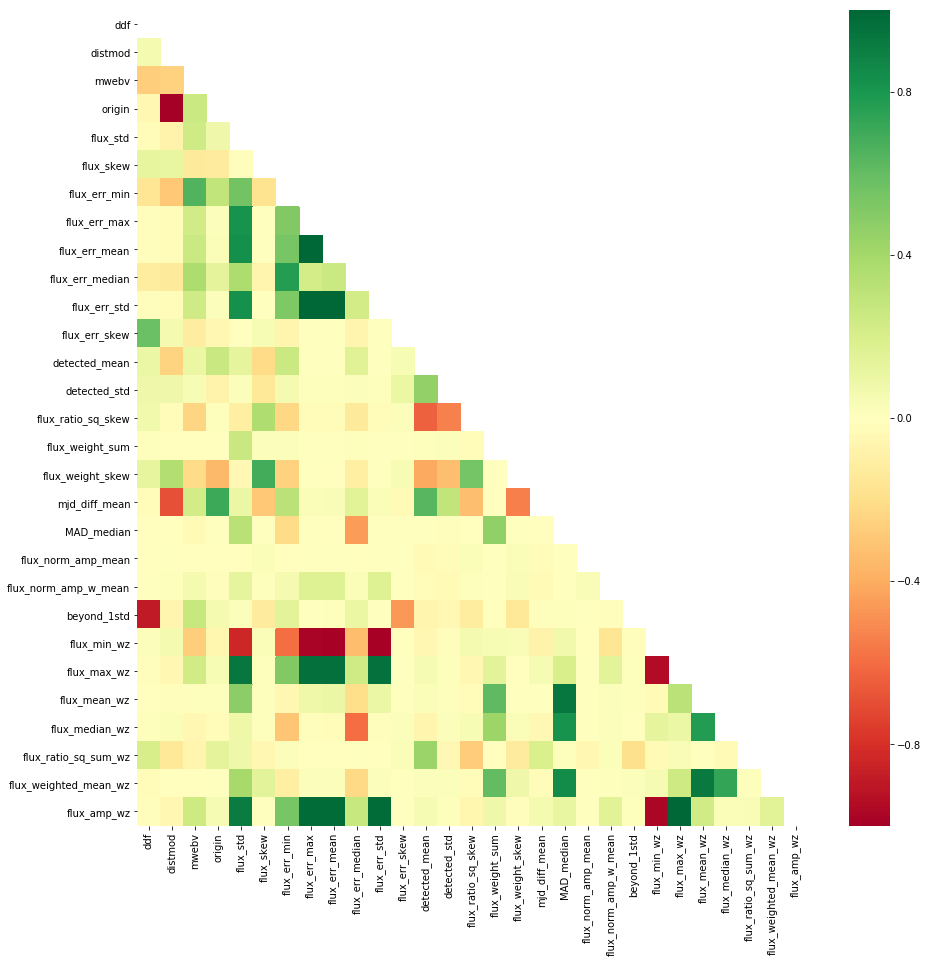

In [24]:
#get correlations of each features in dataset
corrmat = full_df.corr()
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 15))
g = sns.heatmap(corrmat,
            vmin=-1,
            cmap="RdYlGn",
            #annot=True,
            mask = mask);

The above heatmap shows that there are quite a few features that are not correlated. But, there are still some correlated features (positively and negatively) that show up. Due to the high number of features, it is hard to know which features above are the most correlated and the value of the correlation. To get the n number of features that are most correlated and their correlation values use the below code. It removes the redundant features (self-correlation). I will only remove features that have an absolute correlation value of greater than 0.8 with another feature within the important features set.

In [25]:
# below code borrowed from aruns's answer from here: 
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]): # range(len(df.columns)) also would work here
        for j in range(0, i+1): 
            pairs_to_drop.add((cols[i], cols[j])) 
            # 1st iter pair (0,0)
            # 2nd iter pair (1,0), (1,1), etc.
    return pairs_to_drop

def get_top_abs_correlations(df, n):
    feats_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    feats_corr = feats_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return feats_corr[0:n]

In [26]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(full_df, 30))

Top Absolute Correlations
flux_err_max    flux_err_std             0.999573
flux_err_mean   flux_err_std             0.999271
flux_err_max    flux_err_mean            0.998125
distmod         origin                   0.994964
flux_max_wz     flux_amp_wz              0.994650
flux_err_mean   flux_min_wz              0.988319
flux_err_std    flux_min_wz              0.984480
flux_err_max    flux_min_wz              0.982399
flux_err_mean   flux_amp_wz              0.981113
flux_err_std    flux_amp_wz              0.979212
flux_err_max    flux_amp_wz              0.979095
flux_min_wz     flux_amp_wz              0.975339
flux_err_mean   flux_max_wz              0.961168
flux_err_max    flux_max_wz              0.961009
flux_err_std    flux_max_wz              0.960206
flux_min_wz     flux_max_wz              0.947321
flux_std        flux_max_wz              0.936263
MAD_median      flux_mean_wz             0.934225
flux_mean_wz    flux_weighted_mean_wz    0.928160
flux_std        flux_amp

Based on the feature importances, univariate selections and correlations the following unique features were determined to be the most important.
- origin
- distmod
- mjd_diff_mean
- flux_weight_skew
- detected_mean
- flux_skew
- flux_ratio_sq_skew
- flux_ratio_sq_sum_wz
- detected_std
- flux_err_min
- mwebv
- flux_err_median
- flux_std
- ddf
- flux_norm_amp_mean
- MAD_median
- flux_norm_amp_w_mean

### Standardize Features

In [27]:
# create dataframe with only the important features determined above.
df_imp_feats = full_df[['origin', 'distmod', 'mjd_diff_mean', 'flux_weight_skew', 'detected_mean',
                        'flux_skew', 'flux_ratio_sq_skew', 'flux_ratio_sq_sum_wz', 'detected_std', 'flux_err_min',
                        'mwebv', 'flux_err_median', 'flux_std', 'ddf', 'flux_norm_amp_mean',
                        'MAD_median', 'flux_norm_amp_w_mean']]

df_imp_scaled = df_imp_feats.copy() #create copy of dataframe
c_names = ['distmod', 'mjd_diff_mean', 'flux_weight_skew', 'detected_mean', 
           'mwebv', 'flux_err_median', 'flux_std', 'flux_norm_amp_mean', 
           'MAD_median', 'flux_norm_amp_w_mean'] # only these columns need to be scaled



sc_feats = df_imp_scaled[c_names] # create subset dataframe with only columns needed to be scaled
sc_feats = scaler.fit_transform(sc_feats.values) # scale features

df_imp_scaled[c_names] = sc_feats # add scaled features back to dataframe

In [28]:
df_imp_feats['target'] = target_vals.values
df_imp_scaled['target'] = target_vals.values

### Save Reduced Manual Features Dataframe

In [29]:
# save dataframe for training set 2
with open(data_folder / 'reduced_manual_features.pk', 'wb') as f:
    pickle.dump(df_imp_feats, f)
    
# save dataframe for training set 2_scaled
with open(data_folder / 'reduced_manual_features_scaled.pk', 'wb') as f:
    pickle.dump(df_imp_scaled, f)

## Featuretools Feature Selection

The following analysis was based off of [this Medium blog post](https://medium.com/@rrfd/simple-automatic-feature-engineering-using-featuretools-in-python-for-classification-b1308040e183).

In [30]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100

# show types of aggregation functions available 
# can also use type == 'transform' to get the other function types
primitives[primitives['type'] == 'aggregation'] 

,name,type,description
0,last,aggregation,Determines the last value in a list.
1,percent_true,aggregation,Determines the percent of `True` values.
2,time_since_first,aggregation,Calculates the time elapsed since the first datetime (in seconds).
3,num_true,aggregation,Counts the number of `True` values.
4,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
5,min,aggregation,"Calculates the smallest value, ignoring `NaN` values."
6,median,aggregation,Determines the middlemost number in a list of values.
7,all,aggregation,Calculates if all values are 'True' in a list.
8,count,aggregation,"Determines the total number of values, excluding `NaN`."
9,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.


Featuretools works most efficiently when all of the variables are in their lowest possible memory allocation.

In [31]:
print(train.info())
print(train_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421705 entries, 0 to 1421704
Data columns (total 15 columns):
object_id          1421705 non-null int64
mjd                1421705 non-null float64
passband           1421705 non-null int64
flux               1421705 non-null float64
flux_err           1421705 non-null float64
detected           1421705 non-null int64
mjd_diff           236880 non-null float64
flux_ratio_sq      1421705 non-null float64
flux_weight        1421705 non-null float64
flux_weight_sum    1421705 non-null float64
flux_rsq_sum       1421705 non-null float64
flux_w_mean        1421705 non-null float64
flux_median        1421705 non-null float64
MAD                1421705 non-null float64
flux_diff          1421705 non-null float64
dtypes: float64(12), int64(3)
memory usage: 162.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7848 entries, 0 to 7847
Data columns (total 9 columns):
object_id             7848 non-null int64
ddf                   7848 n

In [32]:
train_meta.drop(columns=['target'], inplace=True) # remove the target variable from the proposed feature set

train_meta['origin'] = train_meta.origin.cat.codes
                                               
# object_id should be a int16 or int32 variable instead of int8 in the convert variables function
train['object_id'] = train['object_id'].astype('int32')
train_meta['object_id'] = train_meta['object_id'].astype('int32')

train_clean = convert_variables(train)
train_meta_clean = convert_variables(train_meta)

Create an entity set that defines the relationship between the flux training data and the meta data for the training set.

In [33]:
es = ft.EntitySet('plasticc_set')

es.entity_from_dataframe(dataframe=train_clean, # dataframe that data is located in
                         entity_id='flux', # label for dataframe within the entity set
                         index = 'index') # define which column of the dataframe represents the unique ID

es.entity_from_dataframe(dataframe=train_meta_clean,
                         entity_id='meta',
                         index = 'object_id')

# define which variables are related between the dataframes
# parent dataframe is first (where relationship variable ID only occurs 1x) 
# and child is second (where relationship variable can appear multiple times)
r_meta_flux = ft.Relationship(es['meta']['object_id'], 
                              es['flux']['object_id']) 


# Add the relationship to the entity set
es = es.add_relationship(r_meta_flux)

es

2019-06-29 13:47:09,697 featuretools.entityset - WARNING    index index not found in dataframe, creating new integer column


Entityset: plasticc_set
  Entities:
    flux [Rows: 1421705, Columns: 16]
    meta [Rows: 7848, Columns: 8]
  Relationships:
    flux.object_id -> meta.object_id

In [34]:
feat_matrix, feat_names = ft.dfs(entityset=es,
                                 target_entity='meta', # dataframe features are appended to
                                 agg_primitives=['mean', 'std', 'max', 'min', 'std', 'skew'], # aggs of child entity columns
                                 trans_primitives=['multiply_numeric', 'diff'], # how to combine columns
                                 max_depth=2) # number of columns/individual features that are combined

Define types of features that should be created.

In [35]:
feature_matrix, feature_names = ft.dfs(entityset=es,
                                      target_entity='meta', # dataframe features are appended to
                                      agg_primitives=['mean', 'std', 'max', 'min', 'std', 'skew'], # aggregations to take on the child entity columns
                                      trans_primitives=['multiply_numeric', 'diff', 'divide_numeric'], # how to combine columns
                                      max_depth=2) # number of columns/individual features that are combined

In [36]:
len(feature_names)

13944

Let the Featuretools library auto-create features.

In [37]:
auto_features, auto_feature_names = ft.dfs(entityset=es, target_entity='meta', max_depth = 3)

In [38]:
len(auto_feature_names)

92

### Review and Clean Data

In [39]:
# replace inf/-inf columns with NaN
feature_matrix = feature_matrix.replace([np.inf, -np.inf], np.nan) 

# check for NaN values
print(feature_matrix.isna().any()[lambda x: x].count())

# drop all columns that contain NaN, out of 2742 features
# removing these columns will not make a large difference.
feature_matrix = feature_matrix.dropna(axis='columns') 

4566


In [40]:
auto_features.isna().any()[lambda x: x]
auto_features = auto_features.dropna(axis='columns')

### Dimensionality Reduction

Use the same methods above of univariate selection and then correlation feature reduction to find the most important features that were generated using Featuretools. I only chose to use the mutual information statistical test because it gave almost the exact same features as f-score and feature importances and it does well with non-linear features which may exist in my dataset (for example, the distmod is a logarithm function of the redshift).

In [41]:
MI_top_feats = feature_selection(feature_matrix, target_vals, mutual_info_classif, 20)
MI_top_feats

,Specs,Score
2970,hostgal_specz * MAX(flux.mjd_diff),0.897981
1835,hostgal_specz * MIN(flux.mjd_diff),0.891216
2261,hostgal_specz * MEAN(flux.mjd_diff),0.889129
4732,distmod * hostgal_specz / SKEW(flux.flux_weight),0.875515
4473,hostgal_specz / SKEW(flux.flux_ratio_sq),0.870797
4305,hostgal_specz / SKEW(flux.flux_weight),0.870559
2881,hostgal_specz * MEAN(flux.detected),0.860993
7672,distmod * hostgal_specz / SKEW(flux.flux_ratio_sq),0.856949
6478,hostgal_specz / SKEW(flux.MAD),0.855108
6261,hostgal_specz / SKEW(flux.flux_diff),0.854694


In [42]:
s = get_top_abs_correlations(auto_features, 40)
s.where(s < 1)

SUM(flux.flux_ratio_sq)    MEAN(flux.flux_weight_sum)         NaN
                           MIN(flux.flux_weight_sum)          NaN
                           MAX(flux.flux_weight_sum)          NaN
MAX(flux.flux_w_mean)      MIN(flux.flux_w_mean)              NaN
MAX(flux.flux_median)      MIN(flux.flux_median)              NaN
MIN(flux.flux_weight_sum)  MEAN(flux.flux_weight_sum)         NaN
MAX(flux.mjd_diff)         MEAN(flux.mjd_diff)                NaN
MIN(flux.mjd_diff)         MEAN(flux.mjd_diff)                NaN
MAX(flux.flux_weight_sum)  MIN(flux.flux_weight_sum)          NaN
                           MEAN(flux.flux_weight_sum)         NaN
MIN(flux.flux_w_mean)      MEAN(flux.flux_w_mean)             NaN
MAX(flux.flux_rsq_sum)     MIN(flux.flux_rsq_sum)             NaN
MIN(flux.flux_median)      MEAN(flux.flux_median)             NaN
MAX(flux.flux_rsq_sum)     MEAN(flux.flux_rsq_sum)            NaN
MIN(flux.flux_rsq_sum)     MEAN(flux.flux_rsq_sum)            NaN
MAX(flux.f

No features with an absolute correlation greater than 0.8 show up in the most important features list. Therefore, all 20 features generated in the mutual information list will be used for this training set.

In [43]:
reduced_columns = MI_top_feats['Specs']
feature_matrix_reduced = feature_matrix[reduced_columns]
feature_matrix_reduced['target'] = target_vals.values

In [44]:
# pull out the top features from the auto-created features
feature_selection(auto_features, target_vals, mutual_info_classif, 20)

,Specs,Score
1,hostgal_specz,0.837512
4,distmod,0.773455
2,hostgal_photoz,0.768595
81,MEAN(flux.mjd_diff),0.652929
40,MAX(flux.mjd_diff),0.652007
67,MIN(flux.mjd_diff),0.651820
3,hostgal_photoz_err,0.632446
55,SKEW(flux.flux_weight),0.624653
6,origin,0.600649
60,SKEW(flux.MAD),0.566248


In [45]:
print(get_top_abs_correlations(auto_features, 40))

SUM(flux.flux_ratio_sq)    MEAN(flux.flux_weight_sum)    1.000000
                           MIN(flux.flux_weight_sum)     1.000000
                           MAX(flux.flux_weight_sum)     1.000000
MAX(flux.flux_w_mean)      MIN(flux.flux_w_mean)         1.000000
MAX(flux.flux_median)      MIN(flux.flux_median)         1.000000
MIN(flux.flux_weight_sum)  MEAN(flux.flux_weight_sum)    1.000000
MAX(flux.mjd_diff)         MEAN(flux.mjd_diff)           1.000000
MIN(flux.mjd_diff)         MEAN(flux.mjd_diff)           1.000000
MAX(flux.flux_weight_sum)  MIN(flux.flux_weight_sum)     1.000000
                           MEAN(flux.flux_weight_sum)    1.000000
MIN(flux.flux_w_mean)      MEAN(flux.flux_w_mean)        1.000000
MAX(flux.flux_rsq_sum)     MIN(flux.flux_rsq_sum)        1.000000
MIN(flux.flux_median)      MEAN(flux.flux_median)        1.000000
MAX(flux.flux_rsq_sum)     MEAN(flux.flux_rsq_sum)       1.000000
MIN(flux.flux_rsq_sum)     MEAN(flux.flux_rsq_sum)       1.000000
MAX(flux.f

In [46]:
# create subset of all the automatically produced features based on the maximum mutual information scores
# and then deleting features if they were highly correlated with the others in the group
auto_features_reduced = auto_features[['distmod', 'hostgal_photoz', 'hostgal_photoz_err', 
                                      'origin', 'SKEW(flux.flux)', 'MEAN(flux.flux)', 
                                      'MIN(flux.flux_err)', 'MEAN(flux.detected)', 'SKEW(flux.detected)',
                                      'MEAN(flux.flux_err)', 'SUM(flux.detected)', 'STD(flux.detected)', 
                                      'STD(flux.flux)', 'SKEW(flux.flux_err)']]

In [47]:
#Standardize features by removing the mean and scaling to unit variance
auto_ss = auto_features_reduced.copy()
auto_ss.drop(columns=['origin'])
ss = StandardScaler()
auto_ss = pd.DataFrame(ss.fit_transform(auto_ss))

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int8, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [48]:
auto_ss = convert_variables(auto_ss)

In [49]:
auto_features['target'] = target_vals.values
auto_features_reduced['target'] = target_vals.values

In [50]:
from sklearn_pandas import DataFrameMapper

auto_ss = auto_features_reduced.copy()
auto_ss.drop(columns=['origin'], inplace = True)

mapper = DataFrameMapper([(auto_ss.columns, StandardScaler())])
scaled_features = mapper.fit_transform(auto_ss.copy(), 6) # 6 gives the # of digits to round values to
auto_ss = pd.DataFrame(scaled_features, index=auto_ss.index, columns=auto_ss.columns)

In [51]:
auto_ss['target'] = target_vals.values
auto_ss = auto_ss.assign(origin=pd.Series(auto_features_reduced['origin']))

### Save Featuretools Manual and Auto Features Dataframes

In [52]:
# save dataframe for training sets 3, 4, 5, & 5_scaled
with open(data_folder / 'manual_FT_features.pk', 'wb') as f:
    pickle.dump(feature_matrix_reduced, f)
    
with open(data_folder / 'auto_FT_all_features.pk', 'wb') as f:
    pickle.dump(auto_features, f)
    
with open(data_folder / 'auto_FT_reduced_features.pk', 'wb') as f:
    pickle.dump(auto_features_reduced, f)
    
with open(data_folder / 'auto_FT_ss.pk', 'wb') as f:
    pickle.dump(auto_ss, f)